In [1]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
sys.path.append(os.path.abspath(".."))  #TODO: MAKE THE SRC PACKAGE WORK
from src.training.new_optimised_train import train_autoencoder, train_cellfate
from src.evaluation.evaluate import *
from src.training.loss_functions import *
from src.preprocessing.preprocessing_functions import *
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from src.models import Encoder, Decoder, Discriminator, mlp_classifier, complex_mlp_classifier
from src.utils import *
from tensorflow.keras import layers, Sequential
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

In [2]:
x_train = np.load('../data/images/time_norm_train_images.npy')[:,0,:,:]
y_train = np.load('../data/labels/train_labels_augmented4.npy')
x_test = np.load('../data/images/time_norm_test_images.npy')[:,0,:,:]
y_test = np.load('../data/labels/test_labels.npy')

In [3]:
seed = 42
latent_space_dim = [2, 3] #5, 10, 100

for dim in latent_space_dim:

    np.random.seed(seed)
    confusion_matrices_cellfate = np.zeros((len(latent_space_dim), 2, 2))

    output_dir=f"../results/ls_dimension_study/dim{dim}"
    os.makedirs(output_dir, exist_ok=True)
    
    config_ae = {
                'batch_size': 30,
                'epochs': 15,
                'learning_rate': 0.001,
                'seed': seed,
                'latent_dim': dim,
                'GaussianNoise_std': 0.003,
                'lambda_recon': 5,
                'lambda_adv': 1,
            }

    config_cellfate = {
        'batch_size': 30,
        'epochs': 100,
        'learning_rate': 0.001,
        'seed': seed,
        'latent_dim': dim,
        'GaussianNoise_std': 0.003,
        'lambda_recon': 6,
        'lambda_adv': 4,
        'lambda_cov': 0.0001,
        'lambda_contra': 8,
    }

    config_clf = {
        'batch_size': 30,
        'epochs': 50,
        'learning_rate': 0.001,
        'seed': seed,
        'latent_dim': dim,
    }

    results_autoencoder = train_autoencoder(config_ae, x_train)
    encoder = results_autoencoder['encoder']
    decoder = results_autoencoder['decoder']
    discriminator = results_autoencoder['discriminator']

    # IMAGES: Train AIcellfate with smaller dataset

    results_cellfate = train_cellfate(config_cellfate, encoder, decoder, discriminator, x_train, y_train, x_test, y_test) #lambda_recon=scaled_autoencoder_results['lambda_recon'], lambda_adv=scaled_autoencoder_results['lambda_adv']
    encoder = results_cellfate['encoder']
    decoder = results_cellfate['decoder']
    discriminator = results_cellfate['discriminator']

    save_model_weights_to_disk(encoder, decoder, discriminator, output_dir=output_dir)

    evaluator = Evaluation(output_dir)

    # Evaluate the model (and saving everything)
    z_imgs = encoder.predict(x_train)
    recon_imgs = decoder.predict(z_imgs)
    evaluator.reconstruction_images(x_train, recon_imgs[:,:,:,0], epoch=0)
    evaluator.visualize_latent_space(z_imgs, y_train, epoch=0)
    cov_matrix = cov_loss_terms(z_imgs)[0]
    evaluator.plot_cov_matrix(cov_matrix, epoch=0) # the epoch is a placeholder, it doesnt mean anything (TODO: change these functions)

    tf.keras.utils.set_random_seed(config_clf['seed'])

    classifier = mlp_classifier(latent_dim=config_clf['latent_dim'])
    classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config_clf['learning_rate']), metrics=['accuracy'])

    x_val, x_test_, y_val, y_test_ = train_test_split(encoder.predict(x_test), y_test, test_size=0.5, random_state=42) 
    history = classifier.fit(encoder.predict(x_train), y_train, batch_size=config_clf['batch_size'], epochs=config_clf['epochs'], validation_data=(x_val, y_val)) 

    y_pred = classifier.predict(x_test_)
    y_pred_classes = np.argmax(y_pred, axis=1)
    num_classes = len(np.unique(y_test_))

    # Calculate confusion matrix
    cm = confusion_matrix(y_test_, y_pred_classes)

    class_sums = cm.sum(axis=1, keepdims=True)
    conf_matrix_normalized = cm / class_sums

    confusion_matrices_cellfate[latent_space_dim.index(dim)] = conf_matrix_normalized

    # Save confusion matrix
    plot_confusion_matrix(y_test_, y_pred, num_classes)
    np.save(f"{output_dir}/confusion_matrices_cellfate.npy", confusion_matrices_cellfate)

    

Training with batch size: 30, epochs: 15, learning rate: 0.001, seed: 42, latent dim: 2


/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15: Reconstruction loss: 1.2867, Adversarial loss: 0.7489, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 2/15: Reconstruction loss: 0.7749, Adversarial loss: 0.7269, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 3/15: Reconstruction loss: 0.7638, Adversarial loss: 0.7135, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 4/15: Reconstruction loss: 0.7467, Adversarial loss: 0.7116, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 5/15: Reconstruction loss: 0.7450, Adversarial loss: 0.7094, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 6/15: Reconstruction loss: 0.7531, Adversarial loss: 0.6986, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 7/15: Reconstruction loss: 0.7237, Adversarial loss: 0.7067, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 8/15: Reconstruction loss: 0.7281, Adversarial loss: 0.7037, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 9/15: Reconstruction loss: 0.7274, Adversarial loss: 0.6983, lambda recon: 5.0000, lambda adv: 1.0000


KeyboardInterrupt: 

In [64]:
config = {
    'batch_size': 30,
    'epochs': 50,
    'learning_rate': 0.001,
    'seed': 42,
    'latent_dim': 5,
    'GaussianNoise_std': 0.003,
    'lambda_recon': 5, 
    'lambda_adv': 0.05,
    'lambda_clf': 0.05,
    'lambda_cov': 0.1,
}

img_shape = (x_train.shape[1], x_train.shape[2], 1)
encoder = Encoder(img_shape=img_shape, latent_dim=config['latent_dim'], num_classes=2, gaussian_noise_std=config['GaussianNoise_std']).model
decoder = Decoder(latent_dim=config['latent_dim'], img_shape=img_shape, gaussian_noise_std=config['GaussianNoise_std']).model
discriminator = Discriminator(latent_dim=config['latent_dim']).model

encoder.load_weights("/Users/inescunha/Documents/GitHub/CellFate/results/ls_dimension_study/dim5/encoder.weights.h5")
decoder.load_weights("/Users/inescunha/Documents/GitHub/CellFate/results/ls_dimension_study/dim5/decoder.weights.h5")

# encoder.load_weights("/Users/inescunha/Downloads/encoder60.weights.h5")
# decoder.load_weights("/Users/inescunha/Downloads/decoder60.weights.h5")


/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [65]:
latent_space = encoder.predict(x_train)
cor_vals = [np.corrcoef(np.eye(2)[y_train][:, 0], latent_space[:, i])[0, 1] for i in range(latent_space.shape[1])]
cor_vals = np.array(cor_vals)
feat_0, feat_1 = np.argsort(np.abs(cor_vals))[-2:] 

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [66]:
cor_vals

array([-0.52658754, -0.59992697, -0.44389468, -0.75858021, -0.20159348])

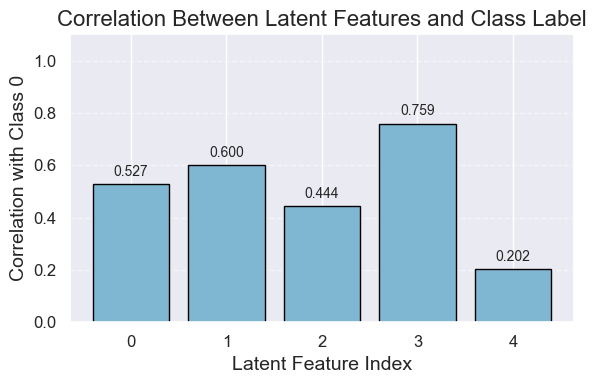

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# X-axis: Feature indices (0 to 99)
feature_indices = np.arange(len(cor_vals))

plt.figure(figsize=(6, 4))
bars = plt.bar(feature_indices, abs(cor_vals), color="#7FB7D3", edgecolor='black')

# Add value labels on top of each bar (3 decimal places)
for bar, value in zip(bars, abs(cor_vals)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f"{value:.3f}",
             ha='center', va='bottom', fontsize=10, fontname='Arial')

# Formatting with Arial font
plt.xlabel("Latent Feature Index", fontsize=14, fontname='Arial')
plt.ylabel("Correlation with Class 0", fontsize=14, fontname='Arial')
plt.title("Correlation Between Latent Features and Class Label", fontsize=16, fontname='Arial')
plt.xticks(fontsize=12, fontname='Arial')
plt.yticks(fontsize=12, fontname='Arial')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.ylim(0, 1.1)  # Add a little space for the text above bars

# Optional: Save plot
#plt.savefig("feature_correlations_3dim.eps", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


In [68]:
import numpy as np

# Assuming: latent_space.shape = (n_cells, 3)
correlation_matrix = np.corrcoef(latent_space.T)  # shape: (3, 3)


In [69]:
correlation_matrix

array([[ 1.        ,  0.34564476, -0.01310027,  0.68227372, -0.14056368],
       [ 0.34564476,  1.        ,  0.32481235,  0.3289125 ,  0.00384571],
       [-0.01310027,  0.32481235,  1.        ,  0.34491265,  0.40310893],
       [ 0.68227372,  0.3289125 ,  0.34491265,  1.        , -0.05556401],
       [-0.14056368,  0.00384571,  0.40310893, -0.05556401,  1.        ]])

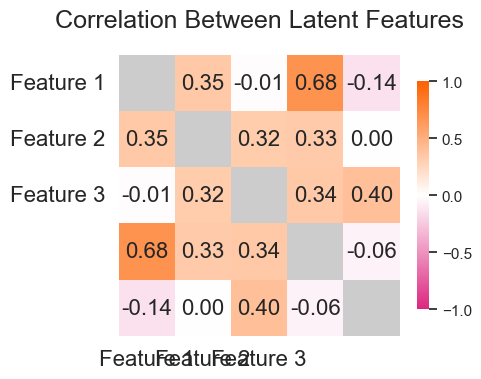

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

# Create annotation labels with 2 decimals only for off-diagonal
annot_labels = correlation_matrix.copy().astype(str)
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if i == j:
            annot_labels[i, j] = ""  # Empty for diagonal
        else:
            annot_labels[i, j] = f"{correlation_matrix[i, j]:.2f}"  # Format to 2 decimals

# Create custom colormap where max value (1.0) is gray
custom_cmap = LinearSegmentedColormap.from_list("magenta_orange", ['#DC267F', '#FFFFFF', '#FE6100'])
# colors = cmap(np.linspace(0, 1, 256))
# colors[-1] = [0.5, 0.5, 0.5, 1.0]  # Gray for value=1.0
# custom_cmap = ListedColormap(colors)

# Plot
plt.figure(figsize=(5, 4))
sns.set(font="Arial")

ax = sns.heatmap(correlation_matrix,
                 annot=annot_labels,
                 fmt='',
                 cmap=custom_cmap,
                 square=True,
                 xticklabels=["Feature 1", "Feature 2"],
                 yticklabels=["Feature 1", "Feature 2"],
                 vmin=-1, vmax=1,
                 cbar_kws={"shrink": 0.8},
                 linewidths=0,
                 linecolor='none',
                 annot_kws={"fontsize": 16, "fontname": "Arial"})

# Add light gray squares on diagonal manually
for i in range(correlation_matrix.shape[0]):
    plt.gca().add_patch(plt.Rectangle((i, i), 1, 1, fill=True, color="#CCCCCC", linewidth=0))
    
# Formatting ticks and title
plt.xticks(fontsize=16, fontname="Arial", rotation=0)
plt.yticks(fontsize=16, fontname="Arial", rotation=0)
plt.title("Correlation Between Latent Features", fontsize=18, fontname="Arial", pad=20)

plt.tight_layout()

# Save high-res figure (optional)
plt.savefig("correlation_matrix_5dim.eps", dpi=300, bbox_inches="tight")

plt.show()

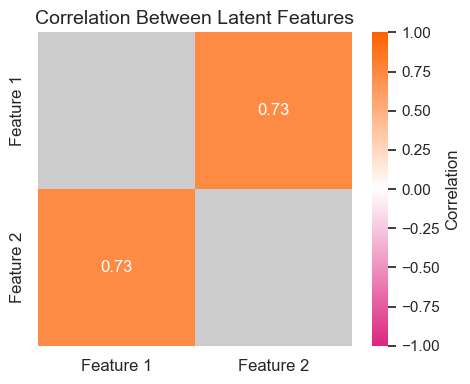

In [61]:
# Custom magenta-to-orange colormap
custom_cmap = LinearSegmentedColormap.from_list("magenta_orange", ['#DC267F', '#FFFFFF', '#FE6100'])

# Example: correlation matrix
correlation_matrix = np.array([[1.0, 0.73], [0.73, 1.0]])

plt.figure(figsize=(5, 4))

# Mask diagonal
mask = np.eye(correlation_matrix.shape[0], dtype=bool)

# Plot heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=custom_cmap,
            square=True, mask=mask, vmin=-1, vmax=1,
            xticklabels=["Feature 1", "Feature 2"],
            yticklabels=["Feature 1", "Feature 2"],
            cbar_kws={'label': 'Correlation'},
            annot_kws={"fontsize": 12, "fontname": "Arial"})

# Add light gray squares on diagonal manually
for i in range(correlation_matrix.shape[0]):
    plt.gca().add_patch(plt.Rectangle((i, i), 1, 1, fill=True, color="#CCCCCC", linewidth=0))

# Formatting
plt.title("Correlation Between Latent Features", fontsize=14, fontname="Arial")
plt.xticks(fontsize=12, fontname="Arial")
plt.yticks(fontsize=12, fontname="Arial")
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True,
            xticklabels=["Feature 1", "Feature 2", "Feature 3"],
            yticklabels=["Feature 1", "Feature 2", "Feature 3"],
            vmin=-1, vmax=1)

plt.title("Correlation Between Latent Features", fontsize=14)
plt.tight_layout()
plt.show()


### Conclusion: it's harder to disentangle...

(5, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
(5, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
(5, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
(5, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
(5, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


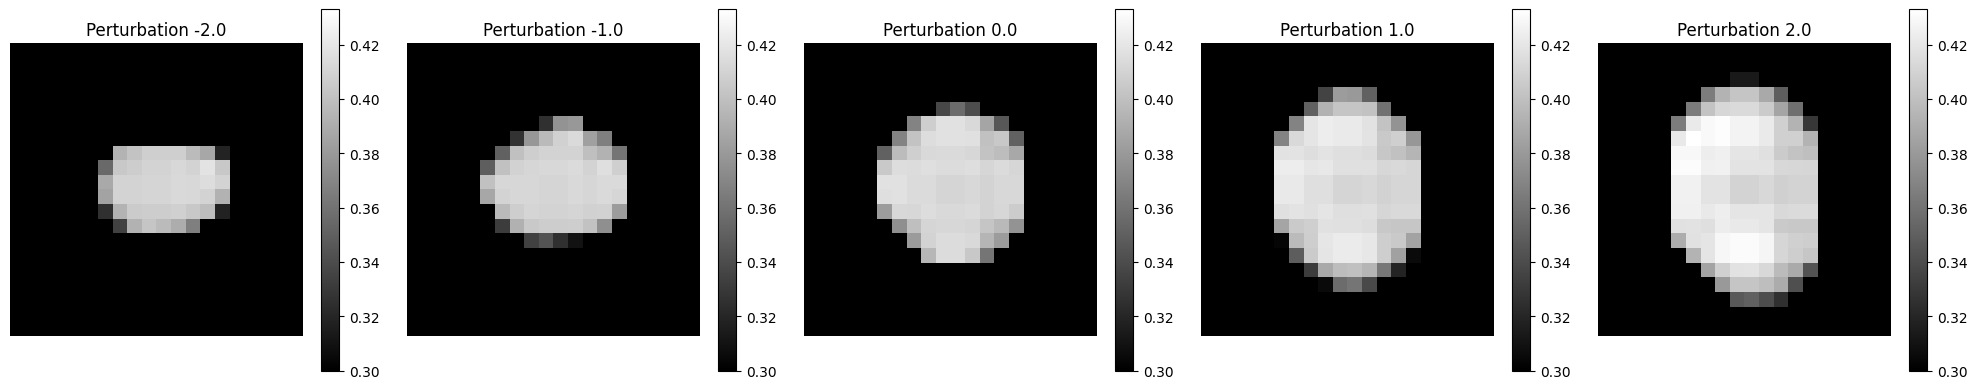

In [59]:
# Load the models after all the training and check the perturbations
baseline_latent_vector = np.zeros((latent_space.shape[1], latent_space.shape[1]), dtype=np.float32)  # Start with a neutral latent vector

# Choose the feature to perturb (e.g., feature 0)
feature_index = 3

# Perturbation range
perturbations = np.linspace(-2, 2, 5) # feature index 0

# Store the perturbed reconstructions
perturbed_reconstructions = []

for value in perturbations:
    # Create a copy of the baseline latent vector
    perturbed_vector = baseline_latent_vector.copy()
    print(perturbed_vector.shape)
    # Modify the selected feature
    perturbed_vector[0, feature_index] = value
    
    # Decode the perturbed vector to generate a synthetic image
    synthetic_image = decoder.predict(perturbed_vector)  # Assuming 'decoder' is your trained decoder model
    
    # Store the result
    perturbed_reconstructions.append(synthetic_image[0])  # Assuming decoder outputs (batch_size, height, width, channels)

# Convert list to numpy array for easier handling
perturbed_reconstructions = np.array(perturbed_reconstructions)

# Plot the results
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
vmin = perturbed_reconstructions.min()
vmax = perturbed_reconstructions.max()

for i in range(5):
    im = axs[i].imshow(perturbed_reconstructions[i, :, :, 0], cmap='gray', vmin=0.3, vmax=vmax)
    axs[i].set_title(f'Perturbation {perturbations[i]}')
    axs[i].axis('off')
    fig.colorbar(im, ax=axs[i])

plt.tight_layout()
plt.savefig("perturbations_feat1.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()


### Precision plot

In [70]:
ls_dimensions = [2, 3, 5, 10, 100]
confusion_matrices = np.zeros((len(ls_dimensions), 2, 2))

confusion_matrices[2] = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/ls_dimension_study/dim5/confusion_matrices_cellfate.npy")
confusion_matrices[3] = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/ls_dimension_study/dim10/confusion_matrices_cellfate.npy")
confusion_matrices[4] = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/ls_dimension_study/dim100/confusion_matrices_cellfate.npy")

ValueError: could not broadcast input array from shape (3,2,2) into shape (2,2)

In [52]:
np.load("/Users/inescunha/Documents/GitHub/CellFate/results/ls_dimension_study/dim5/confusion_matrices_cellfate.npy")

array([[[0.54954955, 0.45045045],
        [0.35714286, 0.64285714]],

       [[0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.        , 0.        ],
        [0.        , 0.        ]]])

In [71]:
confusion_matrices.shape

(5, 2, 2)